# **Multilabel Movie Genre Classification**

# 1. Preprocessing

Before anything, we must import all vital dependencies.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import feature_extraction, feature_selection, pipeline, preprocessing
# Word2Vec Utils
import gensim
import gensim.downloader as gensim_api
# General text preprocessing
import re
import nltk
# Import/export Utils
import csv
import json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then read the datasets (stored in Google Drive for easier access in Colab).

In [3]:
train = pd.read_csv (r'/content/drive/MyDrive/Colab Notebooks/train.csv', encoding='cp1252')
test = pd.read_csv (r'/content/drive/MyDrive/Colab Notebooks/test.csv', encoding='cp1252')
# check a subset to make sure everything's fine
train[['genres', 'overview']].head()
test[['genres', 'overview']].head()

,genres,overview
0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",1951: Andy Schmidt is in his last year of coll...
1,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","Kickboxer 2 is, well, an unnecessary sequel wh..."
2,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",A college-age brother and sister get more than...
3,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...","Having just returned from a mission to Mars, C..."
4,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...","Washington, D.C. psychologist Carol Bennell an..."


The genres in their current format are not useable, so we split them and only keep their name values in a list for each movie.

In [4]:
df = pd.DataFrame({'genres':train['genres'], 'overview':train['overview'] })
y_train=[]

for idx, row in df['genres'].iteritems():
  row = row.replace("'", "\"")
  row = json.loads(row)
  y_train.append([d.get('name') for d in row])

df = pd.DataFrame({'y': y_train, 'text': train['overview']})
print (df[:10])

# now for test set
tdf = pd.DataFrame({'genres':test['genres'], 'overview':test['overview'] })
y_test=[]

for idx, row in tdf['genres'].iteritems():
  row = row.replace("'", "\"")
  row = json.loads(row)
  y_test.append([d.get('name') for d in row])

tdf = pd.DataFrame({'y': y_test, 'text': test['overview']})


                                            y                                               text
0                                    [Comedy]  When Lou, who has become the "father of the In...
1            [Comedy, Drama, Family, Romance]  Mia Thermopolis is now a college graduate and ...
2                                     [Drama]  Under the direction of a ruthless instructor, ...
3                           [Thriller, Drama]  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...
4                          [Action, Thriller]  Marine Boy is the story of a former national s...
5              [Animation, Adventure, Family]  Pinocchio and his friends, a glow worm and a m...
6                          [Horror, Thriller]  A young girl buys an antique box at a yard sal...
7                               [Documentary]  A chronicle which provides a rare window into ...
8  [Action, Comedy, Music, Family, Adventure]  After telling the story of Flint's last journe...
9                             

Let's see all our classes and their frequency.

In [5]:
genre_list = sum(y_train,[])
genre_list = nltk.FreqDist(genre_list) 
n_classes = len(genre_list.keys())
df_genrels = pd.DataFrame({'Genre': list(genre_list.keys()), 
                              'Count': list(genre_list.values())})
print(df_genrels)

              Genre  Count
0            Comedy    676
1             Drama   1011
2            Family    178
3           Romance    387
4          Thriller    545
5            Action    477
6         Animation     89
7         Adventure    295
8            Horror    207
9       Documentary     67
10            Music     65
11            Crime    299
12  Science Fiction    187
13          Mystery    150
14          Foreign     23
15          Fantasy    156
16              War     69
17          Western     30
18          History     96
19         TV Movie      1


The code below counts the number of genres per movie. As the output shows, most movies have 2 or 3 different genres. There are rare instances with 6 or 7 genres, but all movies have at least one genre (no missing label).

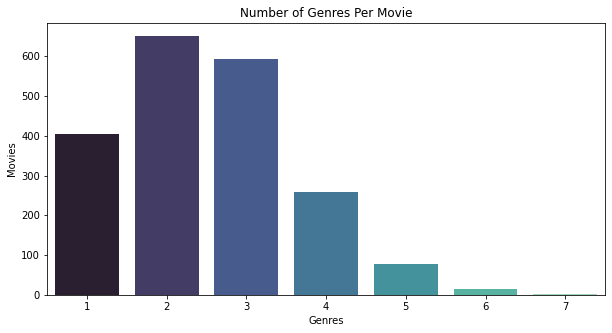

In [8]:
df['movie_genre_count'] = df['y'].apply(lambda text: len(str(text).split(",")))

plt.figure(figsize=(10,5))
sns.countplot(x=df.movie_genre_count, palette='mako')
plt.title("Number of Genres Per Movie")
plt.xlabel("Genres")
plt.ylabel("Movies")
plt.show()

Afterwards, we can use the `explode()` method to replicate the overviews for each genre in the movie, which might later help us in classification with multiple labels.

*Spoiler alert: It doesn't, because the validation tests against each row, so a comedy drama will have the drama label tested twice, once against drama (TP) and once against comedy (TN, but FN if the model has also returned comedy)*

In [ ]:
edf = df.explode('y')
edf[:10].head()

,y,text
0,Comedy,"When Lou, who has become the ""father of the In..."
1,Comedy,Mia Thermopolis is now a college graduate and ...
1,Drama,Mia Thermopolis is now a college graduate and ...
1,Family,Mia Thermopolis is now a college graduate and ...
1,Romance,Mia Thermopolis is now a college graduate and ...


In [ ]:
etdf = tdf.explode('y')
etdf[:5].head()

,y,text
0,Comedy,1951: Andy Schmidt is in his last year of coll...
0,Romance,1951: Andy Schmidt is in his last year of coll...
1,Action,"Kickboxer 2 is, well, an unnecessary sequel wh..."
1,Adventure,"Kickboxer 2 is, well, an unnecessary sequel wh..."
2,Horror,A college-age brother and sister get more than...


To do a triple-check, we do a bar graph of movies per genre.

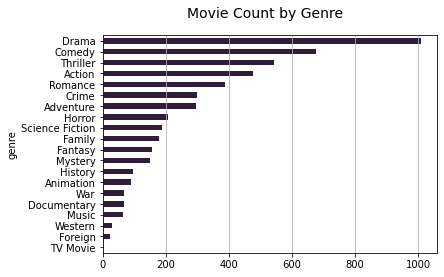

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("Movie Count by Genre", fontsize=14)
edf['y'].reset_index().groupby('y').count().sort_values(by= 
       'index').plot(kind='barh', legend=False, 
        ax=ax, color=sns.color_palette('mako')).grid(axis='x')
ax.set_ylabel('genre')
plt.show()

Now that the basis is ready, we need to prepare the text for learning. The first step is removing all redundant punctuation and words, and normalising the case.
We add the options for lemmatisation and stemming (i.e. switching to root and removing suffixes) using WordNet and Porter.

In [6]:
import string
nltk.download('wordnet')
def clean_text(text, stopwords=None, flem=False, fstem=True):
  text = re.sub(r'[^\w\s\d]', '', str(text).lower().strip())
  text = "".join([char.lower() for char in text if char not in string.punctuation]) 
  lst_text = text.split()
  if stopwords is not None:
    lst_text = [word for word in lst_text if word not in 
                stopwords]
  if fstem == True:
    ps = nltk.stem.porter.PorterStemmer()
    lst_text = [ps.stem(word) for word in lst_text]
  if flem == True:
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lst_text = [lem.lemmatize(word) for word in lst_text]
  text = " ".join(lst_text)
  return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Stopwords can be acquired by using `nltk.corpus`, they are the words that do not lend any meaningful bits to our context.

In [7]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
print(stopwords[:10])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


If we wish to compare the cleaned text with the original, we can easily add it to the dataframe.

In [8]:
df["clean"] = df["text"].apply(lambda x: 
          clean_text(x, flem=True, fstem=False, 
          stopwords=stopwords))
df[['text', 'clean']].head()

,text,clean
0,"When Lou, who has become the ""father of the In...",lou become father internet shot unknown assail...
1,Mia Thermopolis is now a college graduate and ...,mia thermopolis college graduate way genovia t...
2,"Under the direction of a ruthless instructor, ...",direction ruthless instructor talented young d...
3,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,vidya bagchi vidya balan arrives kolkata londo...
4,Marine Boy is the story of a former national s...,marine boy story former national swimmer find ...


Also tidy the tests, that'll be useful later on.

In [9]:
tdf["clean"] = tdf["text"].apply(lambda x: 
          clean_text(x, flem=True, fstem=False, 
          stopwords=stopwords))
tdf[['text', 'clean']].head()

,text,clean
0,1951: Andy Schmidt is in his last year of coll...,1951 andy schmidt last year college taking lif...
1,"Kickboxer 2 is, well, an unnecessary sequel wh...",kickboxer 2 well unnecessary sequel unfortunat...
2,A college-age brother and sister get more than...,collegeage brother sister get bargained road t...
3,"Having just returned from a mission to Mars, C...",returned mission mar commander ross isnt exact...
4,"Washington, D.C. psychologist Carol Bennell an...",washington dc psychologist carol bennell colle...


For now, we will put the `y` (genre list) column in a seperate dataframe, of course, it is likely that MLB lists will be more suited to our needs as we go on.

In [13]:
y_train = df.y
y_test = tdf.y

# 2. Bag of Words (BoW)
We use tf-idf approach to BoW:
$$ tf-idf_{t,d} = tf_{t,d} × idf_t $$
Each document (text entry) will then be represented as a vector, where each component is the tf-idf score of a word in that document.

Naturally, a high tf-idf score means relevance to the topic, while lower (or 0, non representing) means the word is relatively useless in that context.


Note that last we worked with our train set, it was a list of genres, but to work with a multi-label classifier, we need them to be in the form of binary vectors.

Scikit has the perfect solution to this: a *multilabel binarizer* which trains over all labels (to count and index them), then converts each label set to a vector of size N (= total label count in dataset) where each component indicates one of the labels, if set to one, that is a label for that specific row.

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit(df['y'])
y_train = mlb.transform(df['y'])
y_test = mlb.transform(tdf['y'])
print('Binary vector representation:', y_train[1])
print('Which represents:\t', mlb.inverse_transform(y_train)[1])
print('Original data:\n', df.iloc[1,:])

Binary vector representation: [0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0]
Which represents:	 ('Comedy', 'Drama', 'Family', 'Romance')
Original data:
 y                         [Comedy, Drama, Family, Romance]
text     Mia Thermopolis is now a college graduate and ...
clean    mia thermopolis college graduate way genovia t...
Name: 1, dtype: object


To start, we use a tf-idf vectoriser with a maximum of 6000 words for its dictionary.

In [83]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=6000, ngram_range=(1,2), max_df=0.8)

In [84]:
tfidf_x_train = vectorizer.fit_transform(df['clean'])
tfidf_x_test = vectorizer.transform(tdf['clean'])
dict_vocab = vectorizer.vocabulary_
print(dict_vocab.keys())

dict_keys(['lou', 'become', 'father', 'internet', 'shot', 'unknown', 'jacob', 'nick', 'fire', 'time', 'machine', 'save', 'friend', 'time machine', 'mia', 'college', 'graduate', 'way', 'take', 'duty', 'princess', 'best', 'also', 'join', 'summer', 'continues', 'lesson', 'riding', 'horse', 'royal', 'complicated', 'life', 'turned', 'upside', 'learns', 'crown', 'queen', 'earlier', 'expected', 'college graduate', 'best friend', 'complicated life', 'life turned', 'turned upside', 'learns take', 'direction', 'ruthless', 'instructor', 'talented', 'young', 'begin', 'pursue', 'perfection', 'cost', 'even', 'humanity', 'cost even', 'vidya', 'arrives', 'london', 'find', 'missing', 'husband', 'seven', 'month', 'pregnant', 'alone', 'festive', 'city', 'relentless', 'search', 'nothing', 'rely', 'except', 'fragment', 'memory', 'clue', 'seem', 'reach', 'dead', 'end', 'everyone', 'try', 'convince', 'exist', 'slowly', 'seems', 'lie', 'determined', 'unravel', 'truth', 'child', 'find missing', 'try convince',

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

lr = LogisticRegression()
ovrc = OneVsRestClassifier(lr)

In [ ]:
ovrc.fit(tfidf_x_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

Now predict!

In [ ]:
predict = ovrc.predict(tfidf_x_test)

And check with inverse multilabel binarizer:

In [ ]:
import random
for i in random.sample(range(1, 100), 5):
  print('Predicted genre[s]:', mlb.inverse_transform(predict)[i])
  print('True genre[s]:', tdf.iloc[i, 0])

Predicted genre[s]: ('Drama', 'Romance')
True genre[s]: ['Drama', 'History', 'Romance']
Predicted genre[s]: ()
True genre[s]: ['Adventure', 'Horror', 'Action', 'Thriller', 'Science Fiction']
Predicted genre[s]: ()
True genre[s]: ['Drama']
Predicted genre[s]: ('Action',)
True genre[s]: ['Action', 'Crime']
Predicted genre[s]: ('Drama',)
True genre[s]: ['Thriller', 'Drama', 'Horror']


To better understand the workings of this, we use *F1 Score* factor, calculated as below:
$$ F1 = 2×\frac{precision×recall}{precision + recall} $$
or alternatively:
$$ F1 = \frac{TP}{TP + \frac {1}{2}(FP + FN)}$$

It is a very good measure that balances precision with recall, foregoing all the problems with accuracy in an imbalanced dataset (such as this, see the *Movie Count by Genre* chart).

In [11]:
stats = pd.DataFrame(columns = ['name', 'threshold', 'accuracy','precision', 'recall','F1'])

In [12]:
# function to calculate, print, and save vital stats.
def get_stats(y_test, y_pred, name='', threshold=0.5, stats=stats):
  # really bad for this dataset
  accs = accuracy_score(y_test, y_pred)
  # better methods
  pres = precision_score(y_test, y_pred, average='micro', zero_division=1)
  recs = recall_score(y_test, y_pred, average='micro')
  f1s = f1_score(y_test, y_pred, average='micro', zero_division=1)
  # print ('accuracy:\t{}'.format(accs))
  # print ('precision:\t{0:0.5f}'.format(pres))
  # print ('recall:\t\t{0:0.5f}'.format(recs))
  # print ('f1 score:\t{0:0.5f}'.format(f1s))
  temp_df = pd.DataFrame(np.array([[name, threshold, accs, pres, recs, f1s]]), columns=['name', 'threshold', 'accuracy','precision', 'recall','F1'])
  print(tabulate(temp_df, headers='keys', tablefmt='psql'))
  return pd.concat([stats, temp_df])

In [ ]:
stats = get_stats(y_test, predict, 'Logistic Regression', 0.5)

+----+---------------------+-------------+------------+-------------+----------+----------+
|    | name                |   threshold |   accuracy |   precision |   recall |       F1 |
|----+---------------------+-------------+------------+-------------+----------+----------|
|  0 | Logistic Regression |         0.5 |      0.094 |    0.695087 | 0.191252 | 0.299969 |
+----+---------------------+-------------+------------+-------------+----------+----------+


In [13]:
from tabulate import tabulate

def print_stats():
  print(tabulate(stats, headers='keys', tablefmt='psql'))


The f1 score is not all too bad, compared to the relative size of training dataset and its imbalance.

Below is calculation and plot of Precision-Recall curve. The code snippet has been taken and editted from a sample in [Scikit documantations](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#plot-precision-recall-curve-for-each-class-and-iso-f1-curves).

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision = dict()
recall = dict()
avg_precision = dict()
y_score = ovrc.decision_function(tfidf_x_test)

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:,i],y_score[:, i])
    avg_precision[i] = average_precision_score(y_test[:,i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision['micro'], recall['micro'], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
avg_precision['micro'] = average_precision_score(y_test, y_score,
                               average='micro')
print('Average Precision Score (over labels): {0:0.3f}'
      .format(avg_precision["micro"]))

Average Precision Score (over labels): 0.520


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


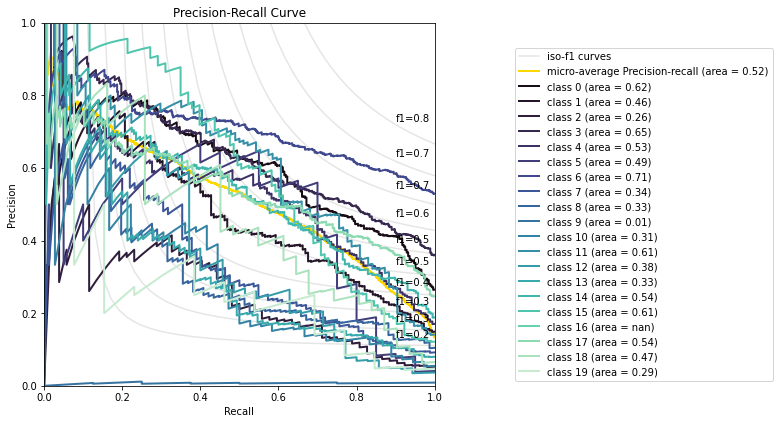

In [ ]:
from itertools import cycle
# setup plot details
colors = cycle(sns.color_palette('mako', n_colors = n_classes))

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=10)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(avg_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('class {0} (area = {1:0.2f})'
                  ''.format(i, avg_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(lines, labels, bbox_to_anchor=(1.05,0.25), loc="lower left",
           bbox_transform=fig.transFigure, ncol=1)
plt.show()

As a little clarification, class 3 is comedy (shown in inverse MLB at the beginning of this section), which is recognised fairly well in both validation and testing, as seen in the sample slices of predictions. It can be due to specific keywords or more training samples (second to drama).

And of course, class 6 is drama, with a high precision-recall average!

## 2.2. Improvements



### 2.2.1. Predict Probability Threshold Modification
By default, the probability threshold has been 0.5, if a genre has more than 50% probability, it will pop up in the predict set. We could go two ways about this, either getting more strict with our predictions or more lenient. Let's try both.

In [ ]:
# first we set a higher threshold
threshold = 0.7
predict_prob = ovrc.predict_proba(tfidf_x_test)
predict_ht = (predict_prob >= threshold).astype(int)
stats = get_stats(y_test, predict_ht, 'Logistic Regression', 0.7)

+----+---------------------+-------------+------------+-------------+-----------+-----------+
|    | name                |   threshold |   accuracy |   precision |    recall |        F1 |
|----+---------------------+-------------+------------+-------------+-----------+-----------|
|  0 | Logistic Regression |         0.7 |      0.014 |    0.901961 | 0.0182903 | 0.0358535 |
+----+---------------------+-------------+------------+-------------+-----------+-----------+


Well, it just got much worse. If we print out the data as before, many more movies come up without any label at all. High precision is of course due to high numbers of True Positives, probabilites should be higher to pick a label, so those few that do get a label are usually right.

For our next trick, we aim for a lower threshold.

In [ ]:
threshold = 0.3
predict_prob = ovrc.predict_proba(tfidf_x_test)
predict_lt = (predict_prob >= threshold).astype(int)
stats = get_stats(y_test, predict_lt, 'Logistic Regression', 0.3)

+----+---------------------+-------------+------------+-------------+----------+----------+
|    | name                |   threshold |   accuracy |   precision |   recall |       F1 |
|----+---------------------+-------------+------------+-------------+----------+----------|
|  0 | Logistic Regression |         0.3 |       0.08 |    0.534904 |  0.49662 | 0.515052 |
+----+---------------------+-------------+------------+-------------+----------+----------+


It's over 0.5, and more balanced between precision/recall Let's get some of the predictions against the true labels.

In [14]:
import random

def get_prediction_samples (predict):
  for i in random.sample(range(1, 100), 5):
    print('Predicted genre[s]:', mlb.inverse_transform(predict)[i])
    print('True genre[s]:', tdf.iloc[i, 0])
    print('\n')

In [ ]:
get_prediction_samples(predict_lt)

Predicted genre[s]: ('Comedy', 'Drama', 'Romance')
True genre[s]: ['Comedy', 'Drama', 'Romance']


Predicted genre[s]: ('Comedy', 'Drama')
True genre[s]: ['Drama', 'Thriller']


Predicted genre[s]: ('Comedy', 'Crime', 'Drama')
True genre[s]: ['Comedy', 'Crime']


Predicted genre[s]: ('Action', 'Comedy', 'Drama')
True genre[s]: ['Action', 'Comedy', 'Fantasy']


Predicted genre[s]: ('Comedy', 'Drama')
True genre[s]: ['Crime', 'Drama', 'Romance']




It still comes up with too much Drama, but it also managed to do a fully correct prediction for a movie with 3 genres. That *is* impressive.

Stretching the point a bit, we try again for a threshold of `0.1`, just because we can.

In [ ]:
threshold = 0.1
predict_prob = ovrc.predict_proba(tfidf_x_test)
predict_llt = (predict_prob >= threshold).astype(int)
stats = get_stats(y_test, predict_llt, 'Logistic Regression', 0.1)

+----+---------------------+-------------+------------+-------------+----------+---------+
|    | name                |   threshold |   accuracy |   precision |   recall |      F1 |
|----+---------------------+-------------+------------+-------------+----------+---------|
|  0 | Logistic Regression |         0.1 |          0 |    0.287917 | 0.861233 | 0.43156 |
+----+---------------------+-------------+------------+-------------+----------+---------+


It got down, although surprisingly, it's still much higher than the default `0.5`, but the golden point was somewhere between `0.1` and `0.3`. Also note the accuracy score.

Why? Because the prediction probability threshold for adding a genre to prediction list gets significantly lower, and given the vocabulary range and training documents on genres like Comdey or Drama, they start popping up whenever, which makes for a lot of FP's, so much that they overwhelm the True Positives.

We can get a better view of how things are going in the test dataset:

In [19]:
def get_genres(entry, predict):
  entry = vectorizer.transform([entry])
  predict_prob = ovrc.predict_proba(entry)
  predict = (predict_prob >= 0.3).astype(int)
  return mlb.inverse_transform(predict)

In [ ]:
for i in range(5): 
  k = tdf.sample(1).index[0] 
  print("Movie: ", tdf.iloc[k,1], "\nPredicted genre: ",
        get_genres(tdf.iloc[k,2]), predict)
  print("Actual genre: ",tdf.iloc[k,0], "\n")


Movie:  A young woman, recently released from a mental hospital, gets a job as a secretary to a demanding lawyer, where their employer-employee relationship turns into a sexual, sadomasochistic one. 
Predicted genre:  [('Comedy', 'Drama', 'Thriller')]
Actual genre:  ['Comedy', 'Drama', 'Romance'] 

Movie:  A young, aspiring filmmaker falls in love with a girl who moves into the house above his, but her sophisticated nature does more harm than good to him. 
Predicted genre:  [('Comedy', 'Drama', 'Romance')]
Actual genre:  ['Drama', 'Romance'] 

Movie:  Officer Alex Kearney patrols an upscale neighborhood in Philadelphia, where he pulls over a well-connected white collar executive who promises to get even with the policeman. Soon, Kearney learns that he is off the cushy suburban beat and must now work in the deadliest precinct in Philly, where he is partnered with tough veteran cop Dennis Curran. Tensions are high between them, but Kearney soon proves he can play just as rough as the cro

### Other Classifiers
So far, we only used a Logistic Regression classifier. But there are other options, e.g. Random Forest and Support Vector classifiers.

Let's start with an **SVC**. We use the general version of SVC with probability enabled and kernel set to linear.

In [ ]:
from sklearn.svm import SVC
random_state = np.random.RandomState(0)
ovrc = OneVsRestClassifier(SVC(class_weight='balanced',
    random_state=random_state, kernel='linear', probability=True))
ovrc.fit(tfidf_x_train, y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight='balanced', coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='linear', max_iter=-1,
                                  probability=True,
                                  random_state=RandomState(MT19937) at 0x7F7963A3C160,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

In [ ]:
predict = ovrc.predict(tfidf_x_test)

In [ ]:
get_prediction_samples(predict)

Predicted genre[s]: ('Crime', 'Drama', 'Thriller')
True genre[s]: ['Drama']


Predicted genre[s]: ('Action', 'Crime', 'Drama', 'Thriller')
True genre[s]: ['Crime', 'Drama', 'Comedy']


Predicted genre[s]: ('Drama', 'History', 'Romance', 'War')
True genre[s]: ['History', 'Drama', 'War']


Predicted genre[s]: ('Comedy', 'Romance')
True genre[s]: ['Action', 'Comedy']


Predicted genre[s]: ('Crime', 'Horror', 'Thriller')
True genre[s]: ['Drama', 'Horror']




So far so very good! Let's take measures.

In [ ]:
stats = get_stats(y_test, predict, 'SVC', '0.5')

+----+--------+-------------+------------+-------------+----------+----------+
|    | name   |   threshold |   accuracy |   precision |   recall |       F1 |
|----+--------+-------------+------------+-------------+----------+----------|
|  0 | SVC    |         0.5 |      0.093 |    0.542212 | 0.477535 | 0.507822 |
+----+--------+-------------+------------+-------------+----------+----------+


It is performing much better than LR with similar properties (although admittedly, balanced class weights might have helped too).

In [ ]:
threshold = 0.3
predict_prob = ovrc.predict_proba(tfidf_x_test)
predict_lt = (predict_prob >= threshold).astype(int)
stats = get_stats(y_test, predict_lt, 'SVC', 0.3)

+----+--------+-------------+------------+-------------+----------+---------+
|    | name   |   threshold |   accuracy |   precision |   recall |      F1 |
|----+--------+-------------+------------+-------------+----------+---------|
|  0 | SVC    |         0.3 |      0.069 |    0.499355 | 0.615507 | 0.55138 |
+----+--------+-------------+------------+-------------+----------+---------+


In [ ]:
get_prediction_samples(predict_lt)

Predicted genre[s]: ('Action', 'Adventure', 'Documentary', 'Science Fiction')
True genre[s]: ['Action', 'Drama', 'Horror', 'Science Fiction', 'Thriller']


Predicted genre[s]: ('Comedy', 'Drama')
True genre[s]: ['Horror', 'Thriller']


Predicted genre[s]: ('Action', 'Crime', 'Drama', 'Thriller')
True genre[s]: ['Action', 'Thriller']


Predicted genre[s]: ('Crime', 'Drama', 'Thriller')
True genre[s]: ['Horror']


Predicted genre[s]: ('Adventure', 'Drama', 'Horror', 'Science Fiction', 'Thriller')
True genre[s]: ['Science Fiction', 'Action', 'Horror']




In [ ]:
threshold = 0.7
predict_prob = ovrc.predict_proba(tfidf_x_test)
predict_ht = (predict_prob >= threshold).astype(int)
stats = get_stats(y_test, predict_ht, 'SVC', 0.7)

+----+--------+-------------+------------+-------------+----------+----------+
|    | name   |   threshold |   accuracy |   precision |   recall |       F1 |
|----+--------+-------------+------------+-------------+----------+----------|
|  0 | SVC    |         0.7 |      0.076 |    0.728376 | 0.190855 | 0.302457 |
+----+--------+-------------+------------+-------------+----------+----------+


Again, 0.3 offers better preformance.

In [ ]:
stats

,name,threshold,accuracy,precision,recall,F1
0,Logistic Regression,0.5,0.094,0.6950867052023122,0.19125248508946321,0.29996881821016524
0,Logistic Regression,0.7,0.014,0.9019607843137255,0.018290258449304174,0.03585346843335931
0,Logistic Regression,0.3,0.08,0.5349036402569594,0.49662027833001987,0.5150515463917524
0,Logistic Regression,0.1,0.0,0.2879170543666091,0.8612326043737575,0.4315600717274357
0,SVC,0.5,0.093,0.5422121896162528,0.4775347912524851,0.5078224101479917
0,SVC,0.3,0.069,0.4993548387096774,0.6155069582504971,0.5513802315227071
0,SVC,0.7,0.076,0.7283763277693475,0.1908548707753479,0.3024574669187145


Next, we use a **Random Forest** classifier.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=10, random_state=0, class_weight='balanced')
ovrc = OneVsRestClassifier(rfc)
ovrc.fit(tfidf_x_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight='balanced',
                                                     criterion='gini',
                                                     max_depth=10,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                        

In [ ]:
predict = ovrc.predict(tfidf_x_test)

In [ ]:
get_prediction_samples(predict)

Predicted genre[s]: ()
True genre[s]: ['Fantasy', 'Animation', 'Family']


Predicted genre[s]: ('Drama',)
True genre[s]: ['Drama']


Predicted genre[s]: ()
True genre[s]: ['Horror', 'Thriller']


Predicted genre[s]: ('Drama', 'Romance')
True genre[s]: ['History', 'Drama', 'War']


Predicted genre[s]: ('Comedy',)
True genre[s]: ['Comedy']




This seems to do worse than the others regarding F1, however, it has a higher accuracy.

In [ ]:
stats = get_stats(y_test, predict, 'Random Forest', 0.5)

+----+---------------+-------------+------------+-------------+----------+----------+
|    | name          |   threshold |   accuracy |   precision |   recall |       F1 |
|----+---------------+-------------+------------+-------------+----------+----------|
|  0 | Random Forest |         0.5 |      0.101 |    0.584423 | 0.408748 | 0.481048 |
+----+---------------+-------------+------------+-------------+----------+----------+


Since we are already getting to many False Positives, we could try lowering the threshold.

In [ ]:
threshold = 0.7
predict_prob = ovrc.predict_proba(tfidf_x_test)
predict_ht = (predict_prob >= threshold).astype(int)
stats = get_stats(y_test, predict_ht, 'Random Forest', 0.7)

+----+---------------+-------------+------------+-------------+----------+------+
|    | name          |   threshold |   accuracy |   precision |   recall |   F1 |
|----+---------------+-------------+------------+-------------+----------+------|
|  0 | Random Forest |         0.7 |          0 |           1 |        0 |    0 |
+----+---------------+-------------+------------+-------------+----------+------+


That might have been a terrible idea...


For the last attempt, we use **AdaBoost** classifier.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ovrc = OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, random_state=0))
ovrc.fit(tfidf_x_train, y_train)
predict = ovrc.predict(tfidf_x_test)
stats = get_stats(y_test, predict, 'Ada Boost', 0.5)

+----+-----------+-------------+------------+-------------+----------+----------+
|    | name      |   threshold |   accuracy |   precision |   recall |       F1 |
|----+-----------+-------------+------------+-------------+----------+----------|
|  0 | Ada Boost |         0.5 |      0.067 |    0.499729 | 0.366203 | 0.422671 |
+----+-----------+-------------+------------+-------------+----------+----------+


Better than LR, but still SVC is the best. Just in case, we alter the threshold.

In [ ]:
threshold = 0.3
predict_prob = ovrc.predict_proba(tfidf_x_test)
predict_lt = (predict_prob >= threshold).astype(int)
stats = get_stats(y_test, predict_lt, 'Ada Boost', 0.3)

+----+-----------+-------------+------------+-------------+----------+----------+
|    | name      |   threshold |   accuracy |   precision |   recall |       F1 |
|----+-----------+-------------+------------+-------------+----------+----------|
|  0 | Ada Boost |         0.3 |          0 |     0.13248 |        1 | 0.233964 |
+----+-----------+-------------+------------+-------------+----------+----------+


Not good.


So far, the best classifier has been SVC with `threshold = 0.3`, closely followed by Logistic Regression classifier with similar threshold.

In [ ]:
stats

,name,threshold,accuracy,precision,recall,F1
0,Logistic Regression,0.5,0.094,0.6950867052023122,0.19125248508946321,0.29996881821016524
0,Logistic Regression,0.7,0.014,0.9019607843137255,0.018290258449304174,0.03585346843335931
0,Logistic Regression,0.3,0.08,0.5349036402569594,0.49662027833001987,0.5150515463917524
0,Logistic Regression,0.1,0.0,0.2879170543666091,0.8612326043737575,0.4315600717274357
0,SVC,0.5,0.093,0.5422121896162528,0.4775347912524851,0.5078224101479917
0,SVC,0.3,0.069,0.4993548387096774,0.6155069582504971,0.5513802315227071
0,SVC,0.7,0.076,0.7283763277693475,0.1908548707753479,0.3024574669187145
0,Random Forest,0.5,0.101,0.5844229675952246,0.4087475149105368,0.48104819840898455
0,Random Forest,0.7,0.0,1.0,0.0,0.0
0,Ada Boost,0.5,0.067,0.49972870320130225,0.3662027833001988,0.4226709499770537


# 3. Word2Vec


## 3.1. Basics

Thanks to the Google pre-trained model on thousands of news articles, we have a trained model for Word2Vec.

In [15]:
wv = gensim.models.KeyedVectors.load_word2vec_format(
    "/content/drive/MyDrive/Colab Notebooks/GoogleNews-vectors-negative300.bin.gz",
    binary=True)
wv.init_sims(replace=True)

Now that the pretrained model has been loaded, we can sneak a peek at some relevant words.

In [16]:
print(tabulate(wv.most_similar('documentary'), headers=['word', 'similarity'], tablefmt='psql'))
print(tabulate(wv.most_similar('adventure'), headers=['word', 'similarity'], tablefmt='psql'))

+-----------------------+--------------+
| word                  |   similarity |
|-----------------------+--------------|
| documentaries         |     0.800146 |
| docu                  |     0.790808 |
| Documentary           |     0.755609 |
| PBS_documentary       |     0.726439 |
| docu_drama            |     0.708184 |
| docudrama             |     0.691389 |
| documentarian         |     0.682752 |
| doco                  |     0.676336 |
| documentary_filmmaker |     0.675116 |
| film                  |     0.634542 |
+-----------------------+--------------+
+-------------------------+--------------+
| word                    |   similarity |
|-------------------------+--------------|
| adventures              |     0.76892  |
| adventuring             |     0.652959 |
| Adventure               |     0.628476 |
| adventurers             |     0.609639 |
| adventurer              |     0.601769 |
| swashbuckling_adventure |     0.599607 |
| intrepid_adventurer     |     0.56561

And a general view at the vocab:

In [96]:
from itertools import islice
print(list(islice(wv.vocab, 1000, 1020)))

['Paul', 'store', 'gets', 'filed', 'huge', 'moving', 'seems', 'met', '####s', 'thousands', 'CEO', 'solutions', 'score', 'content', 'treatment', 'offered', 'built', 'hits', 'present', 'Chicago']


We also need to get average representation of each movie overview.

In [17]:
def average_words(wv, words):
  allw, mean = set(), []
  
  for word in words:
    if isinstance(word, np.ndarray):
      mean.append(word)
    elif word in wv.vocab:
      mean.append(wv.vectors_norm[wv.vocab[word].index])
      allw.add(wv.vocab[word].index)
  # those faulty entries without anything of semantic use
  if not mean:
        return np.zeros(wv.vector_size,)
  mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
  return mean

def average_list(wv, tlist):
  avg_stack = np.vstack([average_words(wv, text) for text in tlist])
  return avg_stack

The text must also be tokenised into words. Note that we use the pre-cleaned text from preprocessing section.

In [18]:
nltk.download('punkt')
def tokenize_text(text):
  tokens = []
  for sent in nltk.sent_tokenize(text, language='english'):
    for word in nltk.word_tokenize(sent, language='english'):
      # useless words
      if len(word) < 2:
        continue
      tokens.append(word)
  return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [19]:
tok_train = df.apply(lambda x: tokenize_text(str(x['clean'])), axis=1).values
tok_test = tdf.apply(lambda x: tokenize_text(str(x['clean'])), axis=1).values

In [20]:
x_train_avg = average_list(wv,tok_train)
x_test_avg = average_list(wv,tok_test)

Remember the MLB from section 2? We need it here, as well, to use with the classifiers.

In [22]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit(df['y'])
y_train = mlb.transform(df['y'])
y_test = mlb.transform(tdf['y'])

The first classifier is a logistic regression similar to BoW.

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

lr = LogisticRegression(n_jobs=1, solver='saga', max_iter=1200, C=1)
ovrc = OneVsRestClassifier(lr)
ovrc.fit(x_train_avg, y_train)
predict = ovrc.predict(x_test_avg)

In [50]:
w2v_stats = pd.DataFrame(columns = ['name', 'threshold', 'accuracy','precision', 'recall','F1'])

In [51]:
w2v_stats = get_stats(y_test, predict, 'Logistic Regression', 0.5, w2v_stats)

+----+---------------------+-------------+------------+-------------+----------+----------+
|    | name                |   threshold |   accuracy |   precision |   recall |       F1 |
|----+---------------------+-------------+------------+-------------+----------+----------|
|  0 | Logistic Regression |         0.5 |      0.114 |    0.683587 | 0.321272 | 0.437111 |
+----+---------------------+-------------+------------+-------------+----------+----------+


The F1 score is higher than what we got in default BoW.

In [ ]:
import random
get_prediction_samples(predict)

Predicted genre[s]: ('Action', 'Science Fiction', 'Thriller')
True genre[s]: ['Adventure', 'Horror', 'Action', 'Thriller', 'Science Fiction']


Predicted genre[s]: ('Comedy', 'Drama')
True genre[s]: ['Comedy']


Predicted genre[s]: ('Horror',)
True genre[s]: ['Comedy']


Predicted genre[s]: ()
True genre[s]: ['Action', 'Science Fiction', 'Adventure']


Predicted genre[s]: ('Action',)
True genre[s]: ['Action', 'Adventure', 'Crime', 'Drama', 'Thriller']




Meh.

## 3.2. Improvements

We found out in section 2.2 that the best threshold is 0.3 in  LR and SVC classifiers. Let's apply that here.

In [52]:
threshold = 0.3
predict_prob = ovrc.predict_proba(x_test_avg)
predict_lt = (predict_prob >= threshold).astype(int)
w2v_stats = get_stats(y_test, predict_lt, 'Logistic Regression', 0.3, w2v_stats)

+----+---------------------+-------------+------------+-------------+----------+----------+
|    | name                |   threshold |   accuracy |   precision |   recall |       F1 |
|----+---------------------+-------------+------------+-------------+----------+----------|
|  0 | Logistic Regression |         0.3 |      0.095 |    0.557047 | 0.594036 | 0.574947 |
+----+---------------------+-------------+------------+-------------+----------+----------+


We just got our best results thus far!

In [55]:
get_prediction_samples(predict_lt)

Predicted genre[s]: ('Drama', 'Thriller')
True genre[s]: ['Drama', 'Thriller']


Predicted genre[s]: ('Action', 'Crime', 'Drama', 'Thriller')
True genre[s]: ['Horror', 'Thriller']


Predicted genre[s]: ('Drama', 'Horror', 'Science Fiction', 'Thriller')
True genre[s]: ['Science Fiction', 'Thriller']


Predicted genre[s]: ('Action', 'Adventure', 'Horror', 'Science Fiction', 'Thriller')
True genre[s]: ['Action', 'Adventure', 'Horror', 'Science Fiction']


Predicted genre[s]: ('Drama', 'Horror', 'Thriller')
True genre[s]: ['Horror']




Let's try again with a different classifier, Random Forest.

In [56]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=10, random_state=0)
ovrc = OneVsRestClassifier(rfc)
ovrc.fit(x_train_avg, y_train)
predict = ovrc.predict(x_test_avg)

In [57]:
w2v_stats = get_stats(y_test, predict, 'Random Forest', 0.5, w2v_stats)

+----+---------------+-------------+------------+-------------+----------+----------+
|    | name          |   threshold |   accuracy |   precision |   recall |       F1 |
|----+---------------+-------------+------------+-------------+----------+----------|
|  0 | Random Forest |         0.5 |      0.084 |     0.68414 | 0.202386 | 0.312366 |
+----+---------------+-------------+------------+-------------+----------+----------+


Not at all impressive. A quick representation shows us the problem is, again, in the imbalance of samples. Drama genre consists of almost half the entries, hence it includes the greatest number of vocabulary, and a lot of test samples will be labelled drama.

In [ ]:
get_prediction_samples(predict)

Predicted genre[s]: ('Drama',)
True genre[s]: ['Action', 'Thriller', 'Crime']


Predicted genre[s]: ('Drama', 'Thriller')
True genre[s]: ['Drama', 'Thriller']


Predicted genre[s]: ('Action',)
True genre[s]: ['Action', 'Crime', 'Thriller']


Predicted genre[s]: ('Drama', 'Thriller')
True genre[s]: ['Family', 'Animation', 'Adventure']


Predicted genre[s]: ()
True genre[s]: ['Horror', 'Thriller']




With BoW + RFC we got very poor results when changing he threshold, but let's lower it to 0.3 here.

In [58]:
threshold = 0.3
predict_prob = ovrc.predict_proba(x_test_avg)
predict_lt = (predict_prob >= threshold).astype(int)
w2v_stats = get_stats(y_test, predict_lt, 'Random Forest', 0.3, w2v_stats)

+----+---------------+-------------+------------+-------------+----------+----------+
|    | name          |   threshold |   accuracy |   precision |   recall |       F1 |
|----+---------------+-------------+------------+-------------+----------+----------|
|  0 | Random Forest |         0.3 |      0.073 |    0.521442 | 0.546322 | 0.533592 |
+----+---------------+-------------+------------+-------------+----------+----------+


Ha! Not as well as LR, but much better than BoW version.

Moving on to SVC.

In [59]:
from sklearn.svm import SVC
random_state = np.random.RandomState(0)
ovrc = OneVsRestClassifier(SVC(class_weight='balanced',
    random_state=random_state, kernel='linear', probability=True))
ovrc.fit(x_train_avg, y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight='balanced', coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='linear', max_iter=-1,
                                  probability=True,
                                  random_state=RandomState(MT19937) at 0x7F014669E380,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

In [60]:
predict = ovrc.predict(x_test_avg)

In [61]:
w2v_stats = get_stats(y_test, predict, 'SVC', 0.5, w2v_stats)

+----+--------+-------------+------------+-------------+----------+----------+
|    | name   |   threshold |   accuracy |   precision |   recall |       F1 |
|----+--------+-------------+------------+-------------+----------+----------|
|  0 | SVC    |         0.5 |       0.04 |     0.41872 | 0.702584 | 0.524722 |
+----+--------+-------------+------------+-------------+----------+----------+


In [62]:
threshold = 0.3
predict_prob = ovrc.predict_proba(x_test_avg)
predict_lt = (predict_prob >= threshold).astype(int)
w2v_stats = get_stats(y_test, predict_lt, 'SVC', 0.3, w2v_stats)

+----+--------+-------------+------------+-------------+----------+----------+
|    | name   |   threshold |   accuracy |   precision |   recall |       F1 |
|----+--------+-------------+------------+-------------+----------+----------|
|  0 | SVC    |         0.3 |      0.089 |    0.540684 | 0.647316 | 0.589215 |
+----+--------+-------------+------------+-------------+----------+----------+


*Gasp!* This is the best so far. SVC has proven itself with two methods. (And the golden 0.3 threshold.)

In [ ]:
get_prediction_samples(predict_lt)

Predicted genre[s]: ('Action', 'Crime', 'Drama', 'Horror', 'Thriller')
True genre[s]: ['Action', 'Horror', 'Thriller']


Predicted genre[s]: ('Comedy', 'Drama', 'Romance')
True genre[s]: ['Drama', 'History', 'Romance']


Predicted genre[s]: ('Fantasy', 'Horror', 'Science Fiction', 'Thriller')
True genre[s]: ['Drama', 'Fantasy', 'Romance', 'Science Fiction']


Predicted genre[s]: ('Comedy', 'Drama', 'Thriller')
True genre[s]: ['Comedy']


Predicted genre[s]: ('Comedy', 'Drama')
True genre[s]: ['Drama']




It probably won't act any better, but for the let's take Ada Boost.

In [63]:
from sklearn.ensemble import AdaBoostClassifier
ovrc = OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, random_state=0))
ovrc.fit(x_train_avg, y_train)
predict = ovrc.predict(x_test_avg)
w2v_stats = get_stats(y_test, predict, 'Ada Boost', 0.5, w2v_stats)

+----+-----------+-------------+------------+-------------+----------+----------+
|    | name      |   threshold |   accuracy |   precision |   recall |       F1 |
|----+-----------+-------------+------------+-------------+----------+----------|
|  0 | Ada Boost |         0.5 |      0.076 |    0.540832 | 0.418688 | 0.471986 |
+----+-----------+-------------+------------+-------------+----------+----------+


What about a Naive Bayes classifier? A Guassian one is not multilabel, but there's a MultiOutputClassifier wrapper for it.

In [64]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
moc = MultiOutputClassifier(gnb)
moc.fit(x_train_avg, y_train)

MultiOutputClassifier(estimator=GaussianNB(priors=None, var_smoothing=1e-09),
                      n_jobs=None)

In [65]:
predict = moc.predict(x_test_avg)
w2v_stats = get_stats(y_test, predict, 'Gaussian NB', 0.5, w2v_stats)

+----+-------------+-------------+------------+-------------+----------+----------+
|    | name        |   threshold |   accuracy |   precision |   recall |       F1 |
|----+-------------+-------------+------------+-------------+----------+----------|
|  0 | Gaussian NB |         0.5 |      0.036 |    0.402956 | 0.650497 | 0.497643 |
+----+-------------+-------------+------------+-------------+----------+----------+


Sadly, this one doesn't natively support thresholding. It might've ben better. :(


---


Now let's get an overview

In [66]:
w2v_stats.sort_values(by=['F1'], ignore_index=True, ascending=False)

,name,threshold,accuracy,precision,recall,F1
0,SVC,0.3,0.089,0.5406841580870143,0.6473161033797217,0.5892146217879117
1,Logistic Regression,0.3,0.095,0.5570469798657718,0.5940357852882704,0.574947084856648
2,Random Forest,0.3,0.073,0.5214421252371917,0.5463220675944334,0.5335922330097087
3,SVC,0.5,0.04,0.41872037914691945,0.7025844930417495,0.5247216035634744
4,Gaussian NB,0.5,0.036,0.40295566502463054,0.6504970178926441,0.49764258555133073
5,Ada Boost,0.5,0.076,0.5408320493066255,0.4186878727634195,0.471985656656208
6,Logistic Regression,0.5,0.114,0.6835871404399323,0.321272365805169,0.43711117121990806
7,Random Forest,0.5,0.084,0.6841397849462365,0.20238568588469186,0.3123657563669837


# 4. Bag of Concepts
The problem with bag of words is that semantic relations cannot be taken into account. What we can do is to grab a clustering algorithm and use on our Word2Vec model to get clusters of 'concepts' instead of single words. Then, we can use these clusters to create a 'bag of concepts' which now has semantical value as well as lexical.

First step is training a Word2Vec model over our cleaned document and save it somewhere (good for future use).

In [21]:
toks = df.clean.to_list()
tok_train = []
for tok in toks:
  tok_train.append(tok.rstrip().split(" "))

In [28]:
def train_w2v(tok_train, embedding_dim=6000, con_size=8,
              min_freq=10, itrs=5):
  model = gensim.models.Word2Vec(size=embedding_dim,
                                 window=con_size, min_count=min_freq, sg=1)
  model.build_vocab(tok_train)
  model.train(tok_train, total_examples=model.corpus_count, epochs=itrs)
  print(model.wv.vocab)

  return model.wv.vectors, model.wv.index2word

In [29]:
wv, i2w = train_w2v(tok_train)

{'become': <gensim.models.keyedvectors.Vocab object at 0x7f248f016e90>, 'father': <gensim.models.keyedvectors.Vocab object at 0x7f248f016c10>, 'shot': <gensim.models.keyedvectors.Vocab object at 0x7f248f016e50>, 'unknown': <gensim.models.keyedvectors.Vocab object at 0x7f248f029210>, 'nick': <gensim.models.keyedvectors.Vocab object at 0x7f248f029fd0>, 'fire': <gensim.models.keyedvectors.Vocab object at 0x7f248f0294d0>, 'time': <gensim.models.keyedvectors.Vocab object at 0x7f248f029910>, 'machine': <gensim.models.keyedvectors.Vocab object at 0x7f248f029bd0>, 'save': <gensim.models.keyedvectors.Vocab object at 0x7f248f029b50>, 'friend': <gensim.models.keyedvectors.Vocab object at 0x7f248f029e50>, 'college': <gensim.models.keyedvectors.Vocab object at 0x7f248f029390>, 'way': <gensim.models.keyedvectors.Vocab object at 0x7f248f029490>, 'take': <gensim.models.keyedvectors.Vocab object at 0x7f248f029410>, 'princess': <gensim.models.keyedvectors.Vocab object at 0x7f248f029450>, 'best': <gensim

Now we need a fit function to cluster (using good old Kmeans), initiate a bag of words, word2concept, and tf-idf calculation of our Bag of Concepts.

In [31]:
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import safe_sparse_dot

def fit_w2v(wv, i2w, src_toks, n_concepts=1000):
  kmeans = KMeans(n_clusters=n_concepts)
  kmeans.fit(wv)
  wv_idx = kmeans.labels_
  bow = pack_bow(i2w, src_toks)
  w2c = W2C(i2w, wv_idx, n_concepts)
  # tf_idf for concepts
  boc = get_tfidf(safe_sparse_dot(bow, w2c))

  return boc, [x for x in zip(i2w, wv_idx)],i2w



And the tf-idf scores, calculated over concepts instead of terms.

In [32]:
from collections import Counter

def pack_bow(i2w, src_toks):
  val = []
  c = []
  r = []
  # reverse the indexing to words
  w2i = {w: i for i, w in enumerate(i2w)}
  for idx, doc in enumerate(src_toks):
    # print(doc)
    toks = doc.rstrip().split(" ")
    n_tok = Counter([w2i[tok] for tok in toks if tok in w2i])
    for i, n in n_tok.items():
      c.append(i)
      r.append(idx)
      # float conversion for tfidf
      val.append(float(n))
  return csr_matrix((val, (r, c)), shape=(idx+1, len(w2i)))


In [33]:
import scipy

def get_tfidf(mat):
  doc_count, n_concepts = mat.shape
  _, non_zero_concept_idx = mat.nonzero()
  tf = np.bincount(non_zero_concept_idx, minlength=n_concepts)
  tf = tf.astype(float)
  idf = np.log(doc_count, tf)
  # handle infinite/NAN
  idf[np.isinf(idf)] = 0
  return safe_sparse_dot (mat, scipy.sparse.diags(idf))

In [34]:
def W2C (i2w, clabels, n_concepts):
  if len(i2w) != len(clabels):
    raise Error('Mismatched dims for words/labels')

  r = [x for x, i2w in enumerate(i2w)]
  c = [x for x in clabels]
  val = [1.0 for x in i2w]

  return csr_matrix((val, (r, c)),
                    shape=(len(i2w), n_concepts))

In [35]:
print(len(i2w))

1216


In [36]:
boc_x_train, w2c_list, i2w_conv = fit_w2v(wv, i2w, toks,  n_concepts=1000)

Let's see what we have now.

In [37]:
from tabulate import tabulate

print(tabulate(w2c_list[20:30], headers=['word', 'concept idx'], tablefmt='psql'))
# and check indexing of words
print(i2w[20:30])

+--------+---------------+
| word   |   concept idx |
|--------+---------------|
| time   |           249 |
| way    |           159 |
| war    |            26 |
| make   |            61 |
| set    |            87 |
| go     |           166 |
| wife   |            93 |
| come   |           142 |
| day    |           112 |
| school |            10 |
+--------+---------------+
['time', 'way', 'war', 'make', 'set', 'go', 'wife', 'come', 'day', 'school']


In [41]:
print(boc_x_train[:30,:20])

  (15, 10)	22.802707378626245
  (17, 16)	7.600902459542082
  (19, 18)	7.600902459542082
  (25, 5)	7.600902459542082
  (26, 19)	7.600902459542082
  (27, 10)	7.600902459542082


This is similar to the tf-idf vectorisation we had in 2.1, perfect.
Now we move on to the familair SVC and MLB.

In [42]:
mlb = MultiLabelBinarizer()
mlb.fit(df['y'])
y_train = mlb.transform(df['y'])
y_test = mlb.transform(tdf['y'])

print('Binary vector representation:', y_train[1])
print('Which represents:\t', mlb.inverse_transform(y_train)[1])
print('\nOriginal data:\n', df.iloc[1,:])

Binary vector representation: [0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0]
Which represents:	 ('Comedy', 'Drama', 'Family', 'Romance')

Original data:
 y                                     [Comedy, Drama, Family, Romance]
text                 Mia Thermopolis is now a college graduate and ...
movie_genre_count                                                    4
clean                mia thermopolis college graduate way genovia t...
Name: 1, dtype: object


In [51]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

random_state = np.random.RandomState(0)
ovrc = OneVsRestClassifier(SVC(class_weight='balanced',
    random_state=random_state, kernel='linear', probability=True))
ovrc.fit(boc_x_train, y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight='balanced', coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='linear', max_iter=-1,
                                  probability=True,
                                  random_state=RandomState(MT19937) at 0x7FB1DBC556B0,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

We have to fit the test data to boc, as well.

In [53]:
test_toks = tdf.clean.to_list()

In [56]:
boc_x_test, w2c_list_test, i2w_conv_test = fit_w2v(wv, i2w, test_toks,  n_concepts=1000)

In [57]:
predict = ovrc.predict(boc_x_test)

In [42]:
import random
get_prediction_samples(predict)

Predicted genre[s]: ('Drama', 'History')
True genre[s]: ['History', 'Drama', 'War']


Predicted genre[s]: ('Action', 'Adventure', 'Comedy', 'Fantasy')
True genre[s]: ['Adventure', 'Fantasy', 'Action']


Predicted genre[s]: ('Animation', 'Drama', 'Horror')
True genre[s]: ['Thriller', 'Drama', 'Horror']


Predicted genre[s]: ('Action', 'Comedy', 'Foreign')
True genre[s]: ['Action', 'Drama', 'Thriller']


Predicted genre[s]: ('Action', 'Comedy', 'Drama', 'History')
True genre[s]: ['Drama', 'Thriller']




Not too bad! We could later get a context similarity between classes. But for now, let's see the stats.

In [58]:
boc_stats = pd.DataFrame(columns = ['name', 'threshold', 'accuracy','precision', 'recall','F1'])

In [59]:
boc_stats = get_stats(y_test, predict, 'SVC', 0.5, boc_stats)

+----+--------+-------------+------------+-------------+----------+----------+
|    | name   |   threshold |   accuracy |   precision |   recall |       F1 |
|----+--------+-------------+------------+-------------+----------+----------|
|  0 | SVC    |         0.5 |      0.005 |    0.201542 | 0.280716 | 0.234629 |
+----+--------+-------------+------------+-------------+----------+----------+


So far, it's worse thn the other two.

In [60]:
threshold = 0.7
predict_prob = ovrc.predict_proba(boc_x_test)
predict_ht = (predict_prob >= threshold).astype(int)
boc_stats = get_stats(y_test, predict_ht, 'SVC', 0.7)

+----+--------+-------------+------------+-------------+------------+-----------+
|    | name   |   threshold |   accuracy |   precision |     recall |        F1 |
|----+--------+-------------+------------+-------------+------------+-----------|
|  0 | SVC    |         0.7 |      0.003 |    0.294118 | 0.00795229 | 0.0154859 |
+----+--------+-------------+------------+-------------+------------+-----------+


That was even worse.

In [61]:
threshold = 0.3
predict_prob = ovrc.predict_proba(boc_x_test)
predict_lt = (predict_prob >= threshold).astype(int)
boc_stats = get_stats(y_test, predict_lt, 'SVC', 0.3)

+----+--------+-------------+------------+-------------+----------+----------+
|    | name   |   threshold |   accuracy |   precision |   recall |       F1 |
|----+--------+-------------+------------+-------------+----------+----------|
|  0 | SVC    |         0.3 |      0.033 |    0.376623 | 0.322863 | 0.347677 |
+----+--------+-------------+------------+-------------+----------+----------+


Once again, 0.3 to the rescue. Let's get some samples.

In [60]:
get_prediction_samples(predict_lt)

Predicted genre[s]: ('Comedy', 'Drama', 'Thriller')
True genre[s]: ['Crime', 'Drama', 'Thriller']


Predicted genre[s]: ('Action', 'Crime', 'Drama', 'Thriller')
True genre[s]: ['Action', 'Drama', 'Western']


Predicted genre[s]: ('Comedy', 'Drama')
True genre[s]: ['Action']


Predicted genre[s]: ('Comedy', 'Drama')
True genre[s]: ['Comedy']


Predicted genre[s]: ('Comedy', 'Drama')
True genre[s]: ['Action', 'Thriller', 'Crime']




You can see how some concepts can cause confusion in the genres. For example, Western lexicon is quite similiar to Crime or even Thriller. Besides, we haven't had enough Western movies to quite discern their own concepts.

## 4.2. Improvements

As before, we test various classifiers and thresholds.

In [48]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_boc_train = TfidfTransformer().fit(boc_x_train)

In [51]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

sgd = SGDClassifier(class_weight='balanced')
ovrc = OneVsRestClassifier(sgd)
ovrc.fit(X=boc_x_train, y=y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                            class_weight='balanced',
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='hinge', max_iter=1000,
                                            n_iter_no_change=5, n_jobs=None,
                                            penalty='l2', power_t=0.5,
                                            random_state=None, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            verbose=0, warm_start=False),
                    n_jobs=None)

In [57]:
predict = ovrc.predict(boc_x_test)

In [59]:
boc_stats = get_stats(y_test, predict, 'SGD', 0.5)

+----+--------+-------------+------------+-------------+----------+----------+
|    | name   |   threshold |   accuracy |   precision |   recall |       F1 |
|----+--------+-------------+------------+-------------+----------+----------|
|  0 | SGD    |         0.5 |      0.007 |    0.215697 | 0.308151 | 0.253766 |
+----+--------+-------------+------------+-------------+----------+----------+


In [64]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=8, random_state=0, class_weight='balanced')
ovrc = OneVsRestClassifier(rfc)
ovrc.fit(boc_x_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight='balanced',
                                                     criterion='gini',
                                                     max_depth=8,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                         

In [66]:
predict = ovrc.predict(boc_x_test)

In [67]:
boc_stats = get_stats(y_test, predict, 'Random Forest', 0.5)

+----+---------------+-------------+------------+-------------+----------+----------+
|    | name          |   threshold |   accuracy |   precision |   recall |       F1 |
|----+---------------+-------------+------------+-------------+----------+----------|
|  0 | Random Forest |         0.5 |      0.018 |    0.296044 | 0.258847 | 0.276199 |
+----+---------------+-------------+------------+-------------+----------+----------+


In [70]:
threshold = 0.3
predict_prob = ovrc.predict_proba(boc_x_test)
predict_lt = (predict_prob >= threshold).astype(int)
boc_stats = get_stats(y_test, predict_lt, 'Random Forest', 0.3)

+----+---------------+-------------+------------+-------------+----------+----------+
|    | name          |   threshold |   accuracy |   precision |   recall |       F1 |
|----+---------------+-------------+------------+-------------+----------+----------|
|  0 | Random Forest |         0.3 |          0 |    0.144618 | 0.988867 | 0.252334 |
+----+---------------+-------------+------------+-------------+----------+----------+


In [71]:
threshold = 0.7
predict_prob = ovrc.predict_proba(boc_x_test)
predict_ht = (predict_prob >= threshold).astype(int)
boc_stats = get_stats(y_test, predict_ht, 'Random Forest', 0.7)

+----+---------------+-------------+------------+-------------+----------+------+
|    | name          |   threshold |   accuracy |   precision |   recall |   F1 |
|----+---------------+-------------+------------+-------------+----------+------|
|  0 | Random Forest |         0.7 |          0 |           1 |        0 |    0 |
+----+---------------+-------------+------------+-------------+----------+------+


In [73]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=500)
ovrc = OneVsRestClassifier(lr)
ovrc.fit(boc_x_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=500,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [75]:
predict = ovrc.predict(boc_x_test)

In [77]:
boc_stats = get_stats(y_test, predict, 'Logistic Rgeression', 0.5)

+----+---------------------+-------------+------------+-------------+----------+----------+
|    | name                |   threshold |   accuracy |   precision |   recall |       F1 |
|----+---------------------+-------------+------------+-------------+----------+----------|
|  0 | Logistic Rgeression |         0.5 |      0.015 |    0.291353 | 0.246521 | 0.267069 |
+----+---------------------+-------------+------------+-------------+----------+----------+


In [78]:
threshold = 0.3
predict_prob = ovrc.predict_proba(boc_x_test)
predict_lt = (predict_prob >= threshold).astype(int)
boc_stats = get_stats(y_test, predict_lt, 'Logistic Regression', 0.3)

+----+---------------------+-------------+------------+-------------+----------+----------+
|    | name                |   threshold |   accuracy |   precision |   recall |       F1 |
|----+---------------------+-------------+------------+-------------+----------+----------|
|  0 | Logistic Regression |         0.3 |       0.01 |    0.277328 | 0.272366 | 0.274824 |
+----+---------------------+-------------+------------+-------------+----------+----------+


In [80]:
get_prediction_samples(predict_lt)

Predicted genre[s]: ('Comedy', 'Drama', 'Romance', 'Thriller')
True genre[s]: ['Action', 'Adventure', 'Crime', 'Drama', 'Thriller']


Predicted genre[s]: ('Action', 'Mystery')
True genre[s]: ['Drama', 'Horror']


Predicted genre[s]: ('Crime', 'Drama', 'Horror', 'Thriller')
True genre[s]: ['Action', 'Adventure']


Predicted genre[s]: ('Action', 'Adventure', 'Science Fiction', 'Thriller')
True genre[s]: ['Adventure', 'Drama', 'Action']


Predicted genre[s]: ('Drama', 'Thriller')
True genre[s]: ['Drama']




# Outro
In essence, the last approach might yet prove to be the best over a more balanced dataset. However, the plot of movies might all centeralise against similar concepts, hence making it difficult to tell apart the genre (especially with micro-genres included along with the more general labels such as Drama).

For this project, however, the Word2Vec approach proved best, utilising SVC's and threshold optimisation. Closely along was SVC's over a Bag-of-Words approach.

